In [69]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import astropy.io.ascii as at
import astropy.io.fits as fits
from astropy.table import Table
from astropy.time import Time
from astropy.coordinates import SkyCoord, Distance
import astropy.units as u
import matplotlib.ticker
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.font_manager import FontProperties
import palettable

from hypra.utils import cat_match, cat_io

Check Gaia HRD Hyades catalog list against this (http://vizier.cfa.harvard.edu/viz-bin/VizieR?-source=J/A+A/616/A10)

Check astrometric noise

Use CMD as a check

BP RP excess indicates phot problem

Gaia quality/membership flags are useful

Include Gaia values in the table to make it easier on people later

Do 1-2 more sanity checks on the actual matching, use a photometry cross-match

Check parallax outliers to see if they're also RA/Dec outliers to confirm outlier status

# Just crossmatching against Gaia

In [70]:
gaia = at.read("gaia_vizier_allhyads_full.csv",delimiter="|",
              data_start=3)
print(gaia.dtype)
gpos = SkyCoord(gaia["RAJ2000"],gaia["DEJ2000"],unit=u.degree)

[('_r', '<f8'), ('DR2Name', '<U28'), ('RA_ICRS', '<f8'), ('e_RA_ICRS', '<f8'), ('DE_ICRS', '<f8'), ('e_DE_ICRS', '<f8'), ('SolID', '<i8'), ('Source', '<i8'), ('RandomI', '<i8'), ('Epoch', '<f8'), ('Plx', '<f8'), ('e_Plx', '<f8'), ('RPlx', '<f8'), ('pmRA', '<f8'), ('e_pmRA', '<f8'), ('pmDE', '<f8'), ('e_pmDE', '<f8'), ('RADEcor', '<f8'), ('RAPlxcor', '<f8'), ('RApmRAcor', '<f8'), ('RApmDEcor', '<f8'), ('DEPlxcor', '<f8'), ('DEpmRAcor', '<f8'), ('DEpmDEcor', '<f8'), ('PlxpmRAcor', '<f8'), ('PlxpmDEcor', '<f8'), ('pmRApmDEcor', '<f8'), ('NAL', '<i8'), ('NAC', '<i8'), ('NgAL', '<i8'), ('NbAL', '<i8'), ('gofAL', '<f8'), ('chi2AL', '<f8'), ('epsi', '<f8'), ('sepsi', '<f8'), ('Solved', '<i8'), ('APF', '<i8'), ('WAL', '<f8'), ('pscol', '<f8'), ('e_pscol', '<f8'), ('fvarpi', '<f8'), ('MatchObsA', '<i8'), ('Nper', '<i8'), ('amax', '<f8'), ('type', '<i8'), ('MatchObs', '<i8'), ('Dup', '<i8'), ('o_Gmag', '<i8'), ('FG', '<f8'), ('e_FG', '<f8'), ('RFG', '<f8'), ('Gmag', '<f8'), ('e_Gmag', '<f8'), ('

In [71]:
# Gaia filtering (from the DR2 HRD paper):
#    RPlx > 10
#    RFG>50
#    RFBP>20
#    RFRP>20
#    E(BR/RP) < 1.3+0.06*(BP-RP)**2
#    E(BR/RP) > 1.0+0.015*(BP-RP)**2 # phot_bp_rp_excess_factor
#    Nper>8 # (visibility periods)
#    chi2AL/(NgAL-5)<1.44*greatest(1,exp(-0.4*(Gmag-19.5)))

#    astrometric_chi2_al/(astrometric_n_good_obs_al-5)<1.44*greatest(1,exp(-0.4*(phot_g_mean_mag-19.5)))

# - astrometric_excess_noise<1 criterion, 
#   but this is less optimised for the bright stars 
#   because of the degrees of freedom (DOF) issue (Lindegren et al. 2018, Appendix A).
# photometric cuts may remove variable stars!

In [72]:
phot_excess = ((gaia["E(BR/RP)"] < (1.3+0.06*gaia["BP-RP"]**2)) &
               (gaia["E(BR/RP)"] > (1.0+0.015*gaia["BP-RP"]**2)))

gexp = np.exp(-0.4*(gaia["Gmag"]-19.5))
gexp[gexp<1] = 1
astrom = (gaia["chi2AL"]/(gaia["NgAL"]-5)) < (1.44*gexp)

hrd_filter = ((gaia["RPlx"]>10) & (gaia["RFG"]>50) & (gaia["RFBP"]>20)
             & (gaia["RFRP"]>20) & phot_excess & (gaia["Nper"]>8)
             & astrom)

In [73]:
hdat,_,_,_ = cat_io.get_data("H")
hpos = SkyCoord(hdat["RA"],hdat["DEC"],unit=u.degree)

In [74]:
hdat = Table(hdat)

In [75]:
idx, sep, _ = hpos.match_to_catalog_sky(gpos)
print(len(idx),len(hpos),len(gpos))

786 786 999


In [76]:
good_match = np.where(sep<(5*u.arcsec))[0]
good_idx = idx[good_match]

print(len(good_idx),len(np.unique(good_idx)))
print(max(good_idx))

784 784
996


In [77]:
hdat["GAIA_QUAL"] = np.zeros(len(hdat),bool)
hdat["GAIA_PARALLAX"] = np.zeros(len(hdat))
hdat["GAIA_PARALLAX_ERR"] = np.zeros(len(hdat))

hdat["GAIA_QUAL"][good_match] = hrd_filter[good_idx]
hdat["GAIA_PARALLAX"][good_match] = gaia["Plx"][good_idx]
hdat["GAIA_PARALLAX_ERR"][good_match] = gaia["e_Plx"][good_idx]

In [78]:
print(len(np.where(hdat["GAIA_QUAL"])[0]),"Good Gaia Stars")
print(len(np.where(hdat["GAIA_QUAL"]==False)[0]),"Low Quality Gaia Stars")
print(len(np.where((hdat["GAIA_QUAL"]==False) & (hdat["BINARY"]>0))[0]),"Low Q, binary")

598 Good Gaia Stars
188 Low Quality Gaia Stars
81 Low Q, binary


In [79]:
hdat["GAIA_PMRA"] = np.zeros(len(hdat))
hdat["GAIA_PMDEC"] = np.zeros(len(hdat))
hdat["GAIA_PMRA_ERR"] = np.zeros(len(hdat))
hdat["GAIA_PMDEC_ERR"] = np.zeros(len(hdat))

hdat["GAIA_PMRA"][good_match] = gaia["pmRA"][good_idx]
hdat["GAIA_PMRA_ERR"][good_match] = gaia["e_pmRA"][good_idx]
hdat["GAIA_PMDEC"][good_match] = gaia["pmDE"][good_idx]
hdat["GAIA_PMDEC_ERR"][good_match] = gaia["e_pmDE"][good_idx]

In [80]:
hdat["GAIA_RV"] = np.zeros(len(hdat))
hdat["GAIA_RV_ERR"] = np.zeros(len(hdat))

hdat["GAIA_RV"][good_match] = gaia["RV"][good_idx]
hdat["GAIA_RV_ERR"][good_match] = gaia["e_RV"][good_idx]

# Comparing earlier values with Gaia

Text(0,0.5,'HIP Parallax')

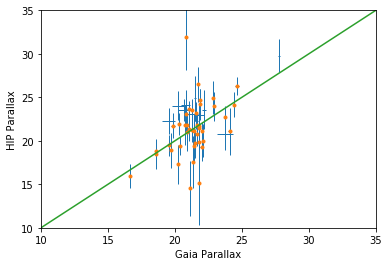

In [81]:
good_hip = hdat["HIP_PARALLAX"]>-999
plt.errorbar(hdat["GAIA_PARALLAX"][good_hip],hdat["HIP_PARALLAX"][good_hip],
            yerr=hdat["HIP_PAR_ERR"][good_hip],xerr=hdat["GAIA_PARALLAX_ERR"][good_hip],
            linewidth=0,elinewidth=1)
good_gaia = good_hip & hdat["GAIA_QUAL"]
plt.plot(hdat["GAIA_PARALLAX"][good_gaia],hdat["HIP_PARALLAX"][good_gaia],'.')

x = np.linspace(0,35)
plt.plot(x,x)
plt.xlim(10,35)
plt.ylim(10,35)

plt.xlabel("Gaia Parallax")
plt.ylabel("HIP Parallax")

Text(0,0.5,'Roeser Parallax')

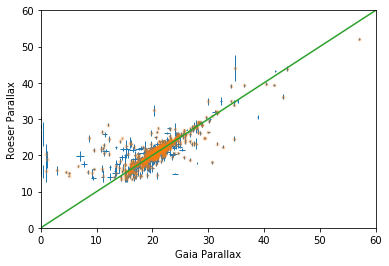

In [82]:
good_ros = hdat["ROESER_PARALLAX"]>-999
plt.errorbar(hdat["GAIA_PARALLAX"][good_ros],
             hdat["ROESER_PARALLAX"][good_ros],
            yerr=hdat["ROESER_PARALLAX_ERR"][good_ros],
             xerr=hdat["GAIA_PARALLAX_ERR"][good_ros],
            linewidth=0,elinewidth=1)
good_gaia = good_ros & hdat["GAIA_QUAL"]
plt.plot(hdat["GAIA_PARALLAX"][good_gaia],
         hdat["ROESER_PARALLAX"][good_gaia],'.',alpha=0.25)

x = np.linspace(0,60)
plt.plot(x,x)
plt.xlim(0,60)
plt.ylim(0,60)

plt.xlabel("Gaia Parallax")
plt.ylabel("Roeser Parallax")

Text(0,0.5,'Goldman Parallax')

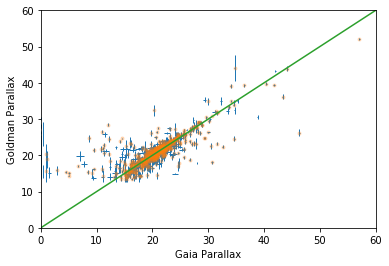

In [83]:
good_g = hdat["GOLDMAN_PLX"]>-999
plt.errorbar(hdat["GAIA_PARALLAX"][good_g],
             hdat["GOLDMAN_PLX"][good_g],
            yerr=hdat["GOLDMAN_E_PLX"][good_g],
             xerr=hdat["GAIA_PARALLAX_ERR"][good_g],
            linewidth=0,elinewidth=1)
good_gaia = good_g & hdat["GAIA_QUAL"]
plt.plot(hdat["GAIA_PARALLAX"][good_gaia],
         hdat["GOLDMAN_PLX"][good_gaia],'.',alpha=0.25)

x = np.linspace(0,60)
plt.plot(x,x)
plt.xlim(0,60)
plt.ylim(0,60)

plt.xlabel("Gaia Parallax")
plt.ylabel("Goldman Parallax")

Text(0,0.5,'Goldman PMRA')

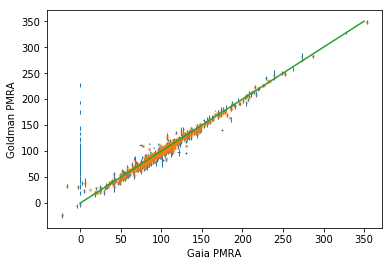

In [84]:
good_g = hdat["GOLDMAN_PMRA"]>-999
plt.errorbar(hdat["GAIA_PMRA"][good_g],
             hdat["GOLDMAN_PMRA"][good_g],
            yerr=hdat["GOLDMAN_E_PMRA"][good_g],
             xerr=hdat["GAIA_PMRA_ERR"][good_g],
            linewidth=0,elinewidth=1)
good_gaia = good_g & hdat["GAIA_QUAL"]
plt.plot(hdat["GAIA_PMRA"][good_gaia],
         hdat["GOLDMAN_PMRA"][good_gaia],'.',alpha=0.25)

x = np.linspace(0,350)
plt.plot(x,x)

plt.xlabel("Gaia PMRA")
plt.ylabel("Goldman PMRA")

Text(0,0.5,'Goldman PMDE')

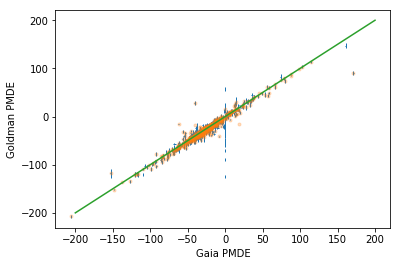

In [85]:
good_g = hdat["GOLDMAN_PMDE"]>-999
plt.errorbar(hdat["GAIA_PMDEC"][good_g],
             hdat["GOLDMAN_PMDE"][good_g],
            yerr=hdat["GOLDMAN_E_PMDE"][good_g],
             xerr=hdat["GAIA_PMDEC_ERR"][good_g],
            linewidth=0,elinewidth=1)
good_gaia = good_g & hdat["GAIA_QUAL"]
plt.plot(hdat["GAIA_PMDEC"][good_gaia],
         hdat["GOLDMAN_PMDE"][good_gaia],'.',alpha=0.25)

x = np.linspace(-200,200)
plt.plot(x,x)

plt.xlabel("Gaia PMDE")
plt.ylabel("Goldman PMDE")

# Look at XYZ (uvw) positions

In [86]:
c = SkyCoord(hdat["RA"]*u.degree, hdat["DEC"]*u.degree,
            pm_ra_cosdec = hdat["GAIA_PMRA"]*u.mas/u.yr,
            pm_dec = hdat["GAIA_PMDEC"]*u.mas/u.yr,
            radial_velocity = hdat["GAIA_RV"]*u.km/u.s,
            obstime=Time(2000, format='decimalyear'),
            distance=Distance(parallax=hdat["GAIA_PARALLAX"] * u.mas))

/Users/sdouglas/anaconda3/envs/py3/lib/python3.6/site-packages/astropy/units/equivalencies.py:50: RuntimeWarning: divide by zero encountered in true_divide
  (si.arcsecond, astrophys.parsec, lambda x: 1. / x)


In [87]:
g = c.transform_to('galactic')
g.set_representation_cls('cartesian')

/Users/sdouglas/anaconda3/envs/py3/lib/python3.6/site-packages/astropy/units/quantity.py:639: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/sdouglas/anaconda3/envs/py3/lib/python3.6/site-packages/astropy/coordinates/angles.py:646: RuntimeWarning: invalid value encountered in less
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/Users/sdouglas/anaconda3/envs/py3/lib/python3.6/site-packages/astropy/coordinates/angles.py:529: RuntimeWarning: invalid value encountered in less
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/Users/sdouglas/anaconda3/envs/py3/lib/python3.6/site-packages/astropy/coordinates/angles.py:529: RuntimeWarning: invalid value encountered in greater
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/Users/sdouglas/anaconda3/envs/py3/lib/python3.6/site-packages/astropy/coordinates/angles.py:646: RuntimeWarning: inval

In [88]:
g.u, g.v, g.w # cartesian XYZ components

(<Quantity [  -44.49626884,   -46.24227576,   -40.43301434,   -48.60518773,
              -43.29811508,   -43.94031614,   -40.74848224,   -42.48926646,
              -41.95689653,   -39.73662142,   -41.18768401,   -53.08661845,
              -40.96826332,   -46.56631625,   -42.23599187,   -42.81018555,
              -44.41231178,   -47.37301509,   -42.80840566,   -42.63143952,
              -44.66522453,   -41.88672638,   -43.09019176,   -49.69286772,
              -43.48798902,   -41.30894294,   -43.934788  ,   -54.06025292,
              -45.2304711 ,   -41.67692215,   -47.33793473,   -45.66810097,
              -41.19617159,   -43.0393413 ,   -66.03240684,   -38.15443424,
              -43.39279422,   -43.71245551,   -42.94222209,   -39.38753283,
              -42.39862641,   -43.14009134,   -41.5400651 ,   -42.60763313,
              -35.86531421,   -60.70726412,   -43.01865237,   -48.74818177,
              -42.08387151,   -44.76880584,   -44.42901416,   -43.05156949,
            

In [89]:
# Roser and Goldman use the van Leeuwen (2009) cluster center

In [90]:
from matplotlib.patches import Circle
def add_circles(ax,center):
    inner = Circle(center,radius=9,fill=False,color="k")
    ax.add_patch(inner)
    middle = Circle(center,radius=18,fill=False,color="k",
                  linestyle="--")
    ax.add_patch(middle)
    outer = Circle(center,radius=30,fill=False,color="k",
                  linestyle=":")
    ax.add_patch(outer)

(0.0, 1.0, 0.0, 1.0)

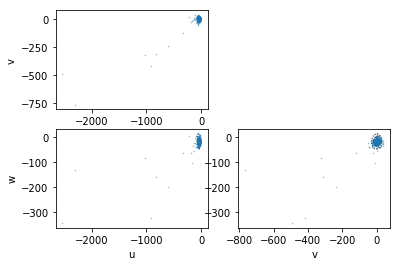

In [91]:
fig, axes = plt.subplots(nrows=2, ncols=2)

axes[0][0].plot(g.u,g.v,'.',alpha=0.5,ms=1)
# axes[0][0].set_xlabel("u")
axes[0][0].set_ylabel("v")
add_circles(axes[0][0],[-43.1,0.7])

axes[1][0].plot(g.u,g.w,'.',alpha=0.5,ms=1)
axes[1][0].set_xlabel("u")
axes[1][0].set_ylabel("w")
add_circles(axes[1][0],[-43.1,-17.3])

axes[1][1].plot(g.v,g.w,'.',alpha=0.5,ms=1)
axes[1][1].set_xlabel("v")
# axes[1][1].set_ylabel("w")
add_circles(axes[1][1],[0.7,-17.3])

axes[0][1].axis('off')

(0.0, 1.0, 0.0, 1.0)

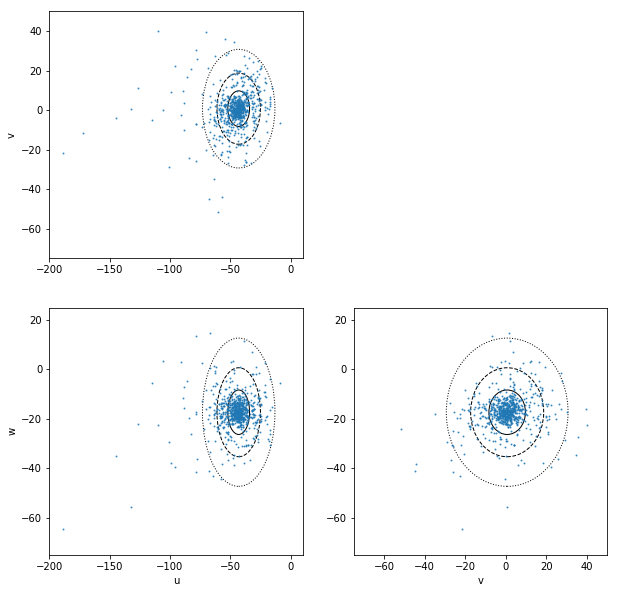

In [92]:
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(10,10))

axes[0][0].plot(g.u,g.v,'.',alpha=0.75,ms=2)
# axes[0][0].set_xlabel("u")
axes[0][0].set_ylabel("v")
add_circles(axes[0][0],[-43.1,0.7])
axes[0][0].set_xlim(-200,10)
axes[0][0].set_ylim(-75,50)

axes[1][0].plot(g.u,g.w,'.',alpha=0.75,ms=2)
axes[1][0].set_xlabel("u")
axes[1][0].set_ylabel("w")
add_circles(axes[1][0],[-43.1,-17.3])
axes[1][0].set_xlim(-200,10)
axes[1][0].set_ylim(-75,25)

axes[1][1].plot(g.v,g.w,'.',alpha=0.75,ms=2)
axes[1][1].set_xlabel("v")
# axes[1][1].set_ylabel("w")
add_circles(axes[1][1],[0.7,-17.3])
axes[1][1].set_xlim(-75,50)
axes[1][1].set_ylim(-75,25)

axes[0][1].axis('off')

(0.0, 1.0, 0.0, 1.0)

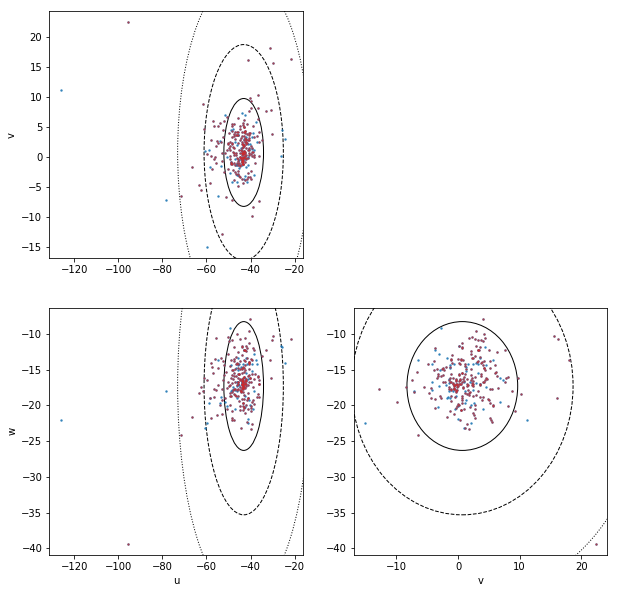

In [94]:
rot = (hdat["PERIOD"]>0) | (hdat["K2FOV_FLAG13"]==2)
rot_good = rot & hdat["GAIA_QUAL"]


fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(10,10))

axes[0][0].plot(g.u[rot],g.v[rot],'.',alpha=0.75,ms=3)
axes[0][0].plot(g.u[rot_good],g.v[rot_good],'.',alpha=0.5,ms=3,color="C3")
# axes[0][0].set_xlabel("u")
axes[0][0].set_ylabel("v")
add_circles(axes[0][0],[-43.1,0.7])

axes[1][0].plot(g.u[rot],g.w[rot],'.',alpha=0.75,ms=3)
axes[1][0].plot(g.u[rot_good],g.w[rot_good],'.',alpha=0.5,ms=3,color="C3")
axes[1][0].set_xlabel("u")
axes[1][0].set_ylabel("w")
add_circles(axes[1][0],[-43.1,-17.3])

axes[1][1].plot(g.v[rot],g.w[rot],'.',alpha=0.75,ms=3)
axes[1][1].plot(g.v[rot_good],g.w[rot_good],'.',alpha=0.5,ms=3,color="C3")
axes[1][1].set_xlabel("v")
# axes[1][1].set_ylabel("w")
add_circles(axes[1][1],[0.7,-17.3])

axes[0][1].axis('off')

In [ ]:
# Check the period and parallax of the outlier

In [96]:
print(len(np.where(rot & np.isnan(g.u))[0]))

9
 PERIOD 
--------
7.956165
   12.61
   17.55
  2.5614
   -99.0
   -99.0
   -99.0
 -9999.0
 -9999.0
GAIA_PARALLAX
-------------
          0.0
          0.0
          0.0
          0.0
          0.0
          0.0
          0.0
          0.0
          0.0


# Compare masses

so, compare how mass changes when absolute K is calculated using Gaia vs an earlier parallax

In [15]:
import convertmass

In [16]:
def calc_mass_unc(mK,mK_err,dist,dist_err):
    # dmod = m-M = 5*log10(d) - 5
    # M = m-dmod = m - 5*log10(d) + 5
    # dM/dd = -5/(d*ln(10))
    dmod = 5.0*np.log10(dist) - 5
    MK = mK - dmod
    
    bad = np.where(mK<-99)[0]
    MK[bad] = -9999

    if type(mK_err)==np.ndarray:
        mK_err_sq = mK_err**2 
    else:
        # actually a fraction, but real errors
        mK_err_sq = (mK_err*mK)**2

    dist_err_sq = (dist_err * 5.0 / (dist * np.log(10.0)))**2

    sigma_MK = np.sqrt(mK_err_sq + dist_err_sq)
    #print(sigma_MK)

    MK_low =  MK + sigma_MK #dimmer/lower mass
    MK_high = MK - sigma_MK #brighter/higher mass
    #print('low',MK_low)
    #print('high',MK_high)
    
    good = np.where((MK>0) & (MK_low>0) & (MK_high>0))[0]

    mass, mass_low, mass_high = np.ones(len(MK))*-9999.,np.ones(len(MK))*-9999.,np.ones(len(MK))*-9999.
    
    mass[good] = convertmass.kraus(MK[good],'K','None')
    mass_low[good] = convertmass.kraus(MK_low[good],'K','None')
    mass_high[good] = convertmass.kraus(MK_high[good],'K','None')

    mass_errs = np.zeros(2*len(mK)).reshape((2,-1))
    
    mass_errs[1][good] = abs(mass_low-mass)[good]
    mass_errs[0][good] = abs(mass_high-mass)[good]

    return mass,mass_errs

In [21]:
def hyades_mass_unc(dist=hdat["DISTANCE"],e_dist=hdat["DISTANCE_ERR"]):
    #mK,mK_err,dist,dist_err
    
    mK = np.copy(hdat["TWOMASS_K"])
    e_mK = np.copy(hdat["TWOMASS_KERR"])
    
    mass,mass_errs = calc_mass_unc(mK, e_mK, dist, e_dist)
    
    good_mass = np.where(mass>0)[0]
    good_errs = np.zeros(2*len(good_mass)).reshape((2,-1))
    good_errs[0] = mass_errs[0][good_mass]
    good_errs[1] = mass_errs[1][good_mass]

    
    plt.plot(mass[good_mass], good_errs[0],'ko')
    plt.plot(mass[good_mass], good_errs[1],'ro')
    plt.xlim(1.2,0.1)
    plt.ylim(0,0.3)
    plt.xlabel("mass")
    plt.ylabel("mass errors")
    
    plt.figure()
    plt.plot(dist,e_dist,'ko')
    plt.xlabel("distance")
    plt.ylabel("distance error")
#     plt.figure()
#     plt.plot(mK,e_mK,'ko')
#     plt.xlim(0,13)
#     plt.ylim(0,0.5)
    
    return mass, mass_errs

0.025564968390695924


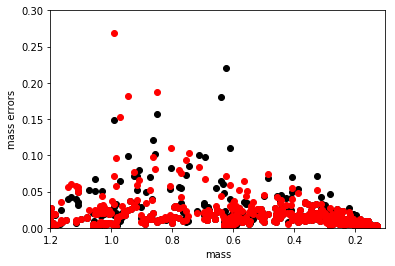

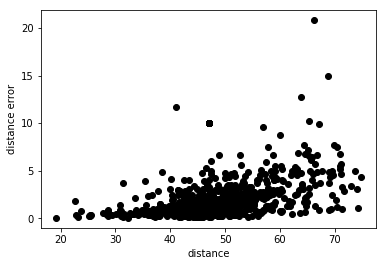

In [22]:
mass, mass_errs = hyades_mass_unc()
good_mass = np.where(mass>0)[0]
mass_errs2 = (mass_errs[0]+mass_errs[1])/2.0
print(np.median(mass_errs2[good_mass]/mass[good_mass]))

In [26]:
gdist = 1000/hdat["GAIA_PARALLAX"]
e_gdist = abs(1000.0 * hdat["GAIA_PARALLAX_ERR"] / (hdat["GAIA_PARALLAX"]**2))
print(gdist)
print(e_gdist)

  GAIA_PARALLAX   
------------------
47.995238872303865
 49.22955742627874
  44.2020209163963
 52.45709010029796
46.689046282851585
 46.53955163795952
 44.17468437188016
 44.89237054162645
45.055801610294345
 49.17653885684218
               ...
 37.30702939047775
37.215533763793005
21.577812829735954
59.335560394700146
  50.1869463752478
 40.50354000939682
 58.46517229686276
42.219388832127265
 36.58246602403468
 44.54283461690935
  678.656260604004
Length = 786 rows
 GAIA_PARALLAX_ERR 
-------------------
 0.8594518762901875
 1.0326743671214182
 0.9014919265373573
 1.0178709570324092
 0.7535800366967403
 0.7892648434117422
 0.6738193658993622
 1.0030272190777978
 0.9218344699966508
 0.6082104914455349
                ...
0.36047994046297044
 0.2164748675045439
0.03990209195834558
 0.3415087465532515
0.20099462100046545
0.16946744661514718
  0.541780954914743
0.18787305401997034
0.20448869815706677
 0.4245897207617984
 124.76958330344398
Length = 786 rows


/Users/sdouglas/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/Users/sdouglas/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


0.007858093535060635


/Users/sdouglas/anaconda3/envs/py3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)


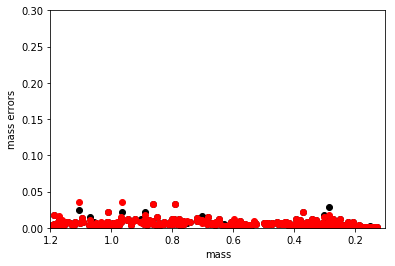

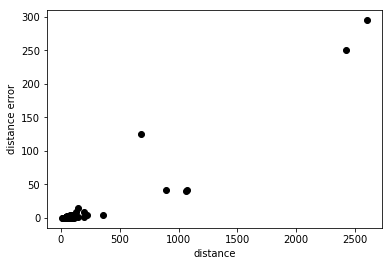

In [27]:
gmass, gmass_errs = hyades_mass_unc(dist=gdist,e_dist=e_gdist)
good_gmass = np.where(gmass>0)[0]
gmass_errs2 = (gmass_errs[0]+gmass_errs[1])/2.0
print(np.median(gmass_errs2[good_gmass]/gmass[good_gmass]))

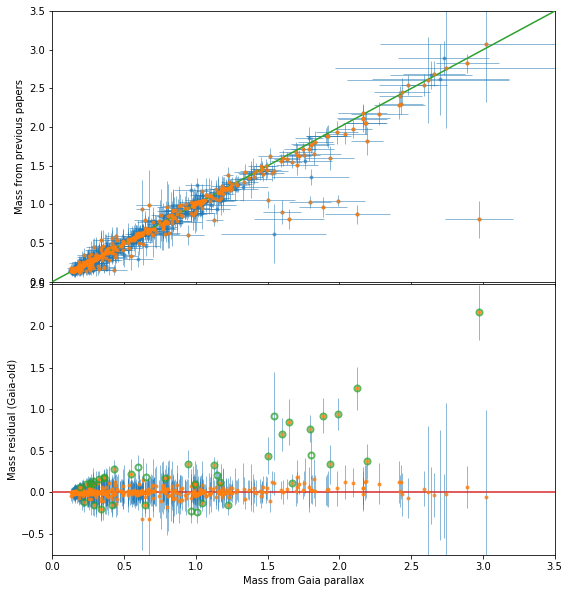

In [64]:
fig, axes = plt.subplots(nrows=2,ncols=1,sharex=True,
                        figsize=(9,10))

axes[0].errorbar(gmass,mass,yerr=np.sqrt(mass_errs2),xerr=np.sqrt(gmass_errs2),
            linewidth=0,elinewidth=1,marker=".",alpha=0.5)

axes[0].plot(gmass[hdat["GAIA_QUAL"]],mass[hdat["GAIA_QUAL"]],
         ".",zorder=4,alpha=0.75)
axes[0].set_xlim(0,3.5)
axes[0].set_ylim(0,3.5)
x = np.linspace(0,4,10)
axes[0].plot(x,x,zorder=3)
axes[0].set_ylabel("Mass from previous papers")
# axes[0].set_xlabel("Mass from Gaia parallax")

mass_diff = gmass-mass
diff_err = np.sqrt(gmass_errs2 + mass_errs2)
mass_diff[(gmass<0) | (mass<0)] = -9999
sig_diff = (abs(mass_diff) - diff_err) > 0

axes[1].errorbar(gmass,mass_diff,diff_err,
            linewidth=0,elinewidth=1,alpha=0.5)
axes[1].plot(gmass[hdat["GAIA_QUAL"]],mass_diff[hdat["GAIA_QUAL"]],
         ".",zorder=4,alpha=0.75)
axes[1].plot(gmass[sig_diff],mass_diff[sig_diff],
         "o",zorder=5,alpha=0.75,mfc="none",mew=2)
axes[1].set_xlim(0,3.5)
x = np.linspace(0,4,10)
axes[1].plot(x,np.zeros_like(x),zorder=3)
axes[1].set_ylabel("Mass residual (Gaia-old)")
axes[1].set_xlabel("Mass from Gaia parallax")
axes[1].set_ylim(-0.75,2.5)
# axes[1].set_ylim(-0.25,0.25)

plt.subplots_adjust(hspace=0.01)